# Import the Dataset

The following imports the dataset from the hugging face repository "surrey-nlp/PLOD-CW". The dataset contains 3 dataset dictionaries - train, validation and test. Each dictionary item has Dataset definitions of "tokens", "pos_tags" and "ner_tags". These are represented as lists of lists of strings, the sublists being a representation of rows.

In [1]:
from datasets import load_dataset, DatasetDict, Dataset # Import dataset import function for hugging face
dataset_dict:DatasetDict = load_dataset("surrey-nlp/PLOD-CW") # import the coursework dataset from

In [2]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 1072
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 126
    })
    test: Dataset({
        features: ['tokens', 'pos_tags', 'ner_tags'],
        num_rows: 153
    })
})

In [3]:
print(f"Type of the Overall Dataset:",type(dataset_dict))
print(f"Type of a Single Dataset:",type(dataset_dict["train"]))
print(f"Type of Single Dataset list:",type(dataset_dict["train"]["tokens"]))

Type of the Overall Dataset: <class 'datasets.dataset_dict.DatasetDict'>
Type of a Single Dataset: <class 'datasets.arrow_dataset.Dataset'>
Type of Single Dataset list: <class 'list'>


#### Dataset Manipulation Instructions

**Dataset** splits into 3 distinct parts:
- train
- validation
- test

To access each call `dataset[set_name]`

For instance `dataset["train"]`

Each set has 3 **features**:
- tokens (words that form a sentance, split into a list)
- pos_tags (part of speech tags)
- ner_tags (name entity recognition tags)

To access each features, call `dataset[set_name][feature_name]`

For instance `dataset["train"]["tokens"]`

First element `dataset["train"]["tokens"][0]`

In [4]:
# train dataset values
train_dataset:Dataset = dataset_dict["train"] # train dataset
train_tokens:list[list[str]] = train_dataset["tokens"] # train dataset tokens
train_pos_tags:list[list[str]] = train_dataset["pos_tags"] # train dataset pos tags
train_ner_tags:list[list[str]] = train_dataset["ner_tags"] # train dataset ner tags

# validation dataset values
validation_dataset= dataset_dict["validation"]
validation_tokens:list[list[str]] = validation_dataset["tokens"]
validation_pos_tags:list[list[str]] = validation_dataset["pos_tags"]
validation_ner_tags:list[list[str]] = validation_dataset["ner_tags"]

# test dataset values
test_dataset:Dataset = dataset_dict["test"]
test_tokens:list[list[str]] = test_dataset["tokens"]
test_pos_tags:list[list[str]] = test_dataset["pos_tags"]
test_ner_tags:list[list[str]] = test_dataset["ner_tags"]

#### List Manipulation

In order to test the dataset, we also need 2 utility functions we will be using: data_to_lower() and flatten_list().

The data_to_lower allows us to manipulate tokens to be lower cased so we would not have issues with upper or lower case words not being recognised. The flatten_list will allow us to take the rows of a list (list of lists) and make it into a single large list that we can iterate over. This will become useful when we want to access all values together.

In [5]:

# lower all characters in a list more simplistically
def data_to_lower(data:list[list[str]]) -> list[list[str]]:
    return [[token.lower() for token in tokens] for tokens in data]

# to easily flatten our data rows into a single list
def flatten_list(given_list:list[list[any]]) -> list[any]:
    return [element for inner_list in given_list for element in inner_list]

# get all unique values in a list, can be used to get also classes
def get_unique_tags(tag_list:list[list[str]]) -> list[str]:
    return list(set(flatten_list(tag_list)))

In [6]:
# Lower case all tokens
train_tokens_lower = data_to_lower(train_tokens)
validation_tokens_lower = data_to_lower(validation_tokens)
test_tokens_lower = data_to_lower(test_tokens)

#### Data Items and Collection

Now that we have our datasets, we will want to manipulate them easier. In order to do this, will create 2 new classes - DataRow and DataCollection. These two classes will allow us to hold each row value in a collection, with useful functions that can be ran on them.

In [7]:
# The Data Item is a row item
# holds an optional row index (0 if none given) and a list of tokens
# as well as pos and ner tags
class DataRow:
    def __init__(self, tokens, pos, ner, row_idx=0):
        self.idx:int = row_idx
        self.tokens:list[str] = tokens
        self.pos:list[str] = pos
        self.ner:list = ner

# The Data collection is the collection of rows
# as well as unique IDs and label (NER) embeddings

class DataCollection:
    def __init__(self, list_collection:list[DataRow], max_token_length=512):
        self.max_token_length:int = max_token_length # max token length (if we tokenize inputs)
        self.collection:list[DataRow] = list_collection # list of rows in the collection
        self.unique_ner_tags:list[str] = []
        self.ner_label2idx:dict = {}
        self.ner_idx2label:dict = {}
        self.ner_as_idx:list[list[int]] = []

    # get a list of token rows
    def get_token_list(self) -> list[list[str]]:
        return [data_item.tokens for data_item in self.collection]

    # get a list of pos rows
    def get_pos_list(self) -> list[list[str]]:
        return [data_item.pos for data_item in self.collection]

    # get a list of ner rows
    def get_ner_list(self) -> list[list[str]]:
        return [data_item.ner for data_item in self.collection]
    
    # turn the ner str list to integer list (embeddings for tokenisation)
    def get_ner_embeddings_list(self, collection:list[DataRow], embeddings:dict) -> list[list[int]]:
        ner_idx_list_collection:list[list[int]] = []
        for data_item in collection:
            ner_idx_list = []
            for ner_tag in data_item.ner:
                ner_idx_list.append(embeddings[ner_tag])
            ner_idx_list_collection.append(ner_idx_list)
        return ner_idx_list_collection
    
    def set_unique_ner_tags(self, tags:list[str]) -> None:
        self.unique_ner_tags = tags
        self.__set_ner_label2idx__(self.unique_ner_tags)
        self.__set_ner_idx2label__(self.ner_label2idx)
        self.__set_ner_as_idx__(self.ner_label2idx)

    def __set_ner_label2idx__(self, tags:list[str]) -> None:
        self.ner_label2idx:dict = {tag:idx for idx, tag in enumerate(tags)}

    def __set_ner_idx2label__(self, embeddings:dict) -> None:
        self.ner_idx2label:dict = {v:k for k, v in embeddings.items()}
    
    def __set_ner_as_idx__(self, embeddings) -> None:
        self.ner_as_idx:list[list[int]] = self.get_ner_embeddings_list(self.collection, embeddings)

Now that we have the functionality to make data collections, we iterate the lists and make them!

In [8]:
# declare a singular tag_list
# this is to be set in collections

# tag_list = ["B-O", "B-AC", "B-LF", "I-LF"]
tag_list = get_unique_tags(train_ner_tags)


# Iterate over each list of tokens, part of speech tags and named entity recognition tags
# and add them to the data collection objects
def data_to_collection(token_list:list[list[str]], pos_list:list[list[str]], ner_list:list[list[str]]) -> DataCollection:
    data_items:list[DataRow] = []
    for idx in range(len(token_list)):
        data_items.append(DataRow(token_list[idx], pos_list[idx], ner_list[idx], idx))
    collection = DataCollection(data_items)
    collection.set_unique_ner_tags(tag_list)
    return collection



train_collection = data_to_collection(train_tokens_lower, train_pos_tags, train_ner_tags)
validation_collection = data_to_collection(validation_tokens_lower, validation_pos_tags, validation_ner_tags)
test_collection = data_to_collection(test_tokens_lower, test_pos_tags, test_ner_tags)

# set all collections to have the same tag list.
# this will avoid metric issues down the line!
train_collection.set_unique_ner_tags(tag_list)
validation_collection.set_unique_ner_tags(tag_list)
test_collection.set_unique_ner_tags(tag_list)

#### Dataset Analysis

We can view the total number of tokens in each of the datasets by flattening each of the token lists and getting their length

In [9]:
train_tt:int = len(flatten_list(train_collection.get_token_list())) # train total tokens
val_tt:int = len(flatten_list(validation_collection.get_token_list()))
test_tt:int = len(flatten_list(test_collection.get_token_list()))
total_tok:int = train_tt + val_tt + test_tt

print("Train total tokens: ", train_tt)
print("Validation total tokens: ", val_tt)
print("Test total tokens: ", test_tt)
print("Total dataset tokens: ", total_tok)

Train total tokens:  40000
Validation total tokens:  5000
Test total tokens:  5000
Total dataset tokens:  50000


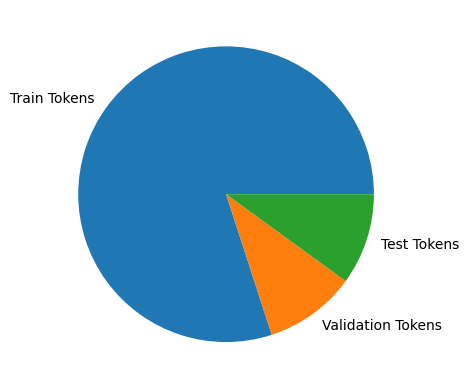

In [10]:
import matplotlib.pyplot as plt
import numpy as np

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

chart = np.array([(train_tt/total_tok), (val_tt/total_tok), (test_tt/total_tok)])
chart_labels = ["Train Tokens", "Validation Tokens", "Test Tokens"]

plt.pie(chart, labels = chart_labels)
plt.show()

When we calculate the total number of unique tokens, we can see that without lowering the data, we have a lot more words that are considered "unique", even though they are the same word. This is why we have to make all words lowercase.

In [11]:
def get_word_frequency(data_list:list[str]) -> dict:
    word_frequency:dict = {"total_tokens":0, "unique_tokens":0, "unique_token_frequency":{}}
    for value in data_list:
        if value not in word_frequency["unique_token_frequency"].keys():
            word_frequency["unique_token_frequency"][value] = 1
            word_frequency["unique_tokens"] += 1
        else:
            word_frequency["unique_token_frequency"][value] += 1
        word_frequency["total_tokens"] += 1
    return word_frequency

print("Before lower in train dataset unique:",get_word_frequency(flatten_list(train_tokens))["unique_tokens"])
print("After \tlower unique:", get_word_frequency(flatten_list(train_collection.get_token_list()))["unique_tokens"])

Before lower in train dataset unique: 9133
After 	lower unique: 8339


We can also view each of the unique tokens in our frequency list. For now we can print the top 10 most frequent words.

{',': 2268, '(': 1583, ')': 1575, 'the': 1270, '.': 1073, 'of': 1006, 'and': 903, '-': 901, ';': 691, 'in': 639}


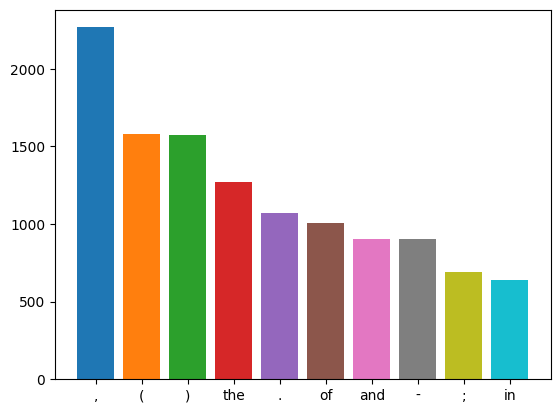

In [12]:
train_frequency:dict = get_word_frequency(flatten_list(train_collection.get_token_list()))
sorted_list = sorted(train_frequency["unique_token_frequency"].items(), key=lambda t: t[1], reverse=True)
sorted_list = sorted_list[:10]
sorted_dict = {item_tuple[0]:item_tuple[1] for item_tuple in sorted_list}
print(sorted_dict)
plt.bar(sorted_dict.keys(), sorted_dict.values(), color=colors)
plt.show() # frequency of classes / labels

From this we can see that the most common words are actually punctuations, rather than words. In the data preprocessing step, we can remove some of these stopwords and see if it improves our accuracy.

Next, let us look at the labels in a given data collection:

{'B-O': 32971, 'B-LF': 1462, 'I-LF': 3231, 'B-AC': 2336}


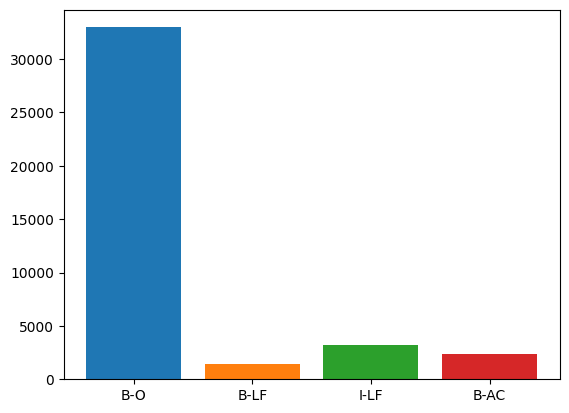

In [13]:
tag_frequency = get_word_frequency(flatten_list(train_collection.get_ner_list()))["unique_token_frequency"]
print(tag_frequency)
plt.bar(tag_frequency.keys(), tag_frequency.values(), color=colors)
plt.show() # frequency of classes / labels

We can see that we have 4 labels, B-O standing for not an abbreviation or long form, B-AC being an abbreviation, B-LF is long form beginning and I-LF is the continuation of the long form. All long forms will be represented as starting with B-LF followed by I-LF if any.

From the plot, we can see that the dataset is imbalanced towards the B-O class. Data imbalance is usually resolved by either oversampling or undersampling the dataset. In the case of oversampling, we would add more values, either from the test or validation set (while removing them from their corresponding set) and adding them to the training set to increase the values of the B-LF, I-LF and B-AC classes. For undersampling we would remove values of B-O. This would be most easily done by removing stop words and their corresponding NER values.

#### Data Pre-processing

Now that we have completed analysing the data, let us start the first experiment by pre-processing and training the data. Firstly, let's look at the first 10 words of the first 5 rows from the training collection:

In [14]:
for tokens in train_tokens[:3]:
    print(tokens[:5])

['For', 'this', 'purpose', 'the', 'Gothenburg']
['The', 'following', 'physiological', 'traits', 'were']
['Minor', 'H', 'antigen', 'alloimmune', 'responses']


We will notice that there are already uppercase tokens here, which would count as "unique" compared to their lowercase counterparts, even though they represent the same words. For this, we will want to lowercase the words in the lists. Luckily, we have already created lowercase lists and loaded this to our collections, so if we look at the rows there we will note that all the letters are uniform.

In [15]:
for data_item in train_collection.collection[:3]:
    print(data_item.tokens[:5])

['for', 'this', 'purpose', 'the', 'gothenburg']
['the', 'following', 'physiological', 'traits', 'were']
['minor', 'h', 'antigen', 'alloimmune', 'responses']


Now that all of our tokens are lowercase, lets try removing the punctuations from our training corpus:

In [16]:
import string
def remove_values(data_collection:DataCollection, remove_values:list|str) -> DataCollection:
    collection:list[DataRow] = []
    for data_row in data_collection.collection:
        new_row:DataRow = DataRow([], [], [])
        for item_idx, token in enumerate(data_row.tokens):
            if token not in remove_values:
                new_row.tokens.append(data_row.tokens[item_idx])
                new_row.pos.append(data_row.pos[item_idx])
                new_row.ner.append(data_row.ner[item_idx])
        if len(new_row.tokens) > 0:
            collection.append(new_row)
    new_collection = DataCollection(collection)
    new_collection.set_unique_ner_tags(tag_list)
    return new_collection

print("Token number Before punctuation remove:", len(flatten_list(train_collection.get_token_list())), "| NER len:", len(flatten_list(train_collection.get_ner_list())))
train_collection_no_punct = remove_values(train_collection, string.punctuation)
print("Token number After punctuation remove:", len(flatten_list(train_collection_no_punct.get_token_list())), "| NER len:", len(flatten_list(train_collection_no_punct.get_ner_list())))


Token number Before punctuation remove: 40000 | NER len: 40000
Token number After punctuation remove: 30582 | NER len: 30582


With the punctuations removed, we are left with 30582 tokens. Let's now also remove the stopwords. We can get stopwords from the NLTK library.

In [17]:

import nltk
from nltk.corpus import stopwords
 
nltk.download('stopwords')
stop_words:list[str] = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olive\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
train_collection_no_stopwords = remove_values(train_collection, stop_words)

print("Token number Before stopword remove:", len(flatten_list(train_collection.get_token_list())), "| NER len:", len(flatten_list(train_collection.get_ner_list())))
print("Token number After stopword remove:", len(flatten_list(train_collection_no_stopwords.get_token_list())), "| NER len:", len(flatten_list(train_collection_no_stopwords.get_ner_list())))

punct_and_stop:list[str] = list(stop_words)
punct_and_stop += [*string.punctuation]

train_collection_all_removed = remove_values(train_collection, punct_and_stop)

print("Token number After all remove:", len(flatten_list(train_collection_all_removed.get_token_list())), "| NER len:", len(flatten_list(train_collection_all_removed.get_ner_list())))


Token number Before stopword remove: 40000 | NER len: 40000
Token number After stopword remove: 31497 | NER len: 31497
Token number After all remove: 22079 | NER len: 22079


If we remove the stopwords we are left with 31497 tokens. Removing both the stopwords and punctuations leaves us with 22079 words. But what if we were to also only keep unique tokens? We would lose sequential data (as this would not always guarantee B-LF to be followed by I-LF) and we would expect to have worse results in recognition, but to test this out, let us only keep unique words and then also remove stopwords and punctuations.

In [19]:
def unique_collection(data_collection:DataCollection) -> DataCollection:
    collection:list[DataRow] = []
    unique_tokens:list[str] = []
    for data_row in data_collection.collection:
        new_row:DataRow = DataRow([], [], [])
        for item_idx, token in enumerate(data_row.tokens):
            if token not in unique_tokens:
                new_row.tokens.append(data_row.tokens[item_idx])
                new_row.pos.append(data_row.pos[item_idx])
                new_row.ner.append(data_row.ner[item_idx])
                unique_tokens.append(token)
        if len(new_row.tokens) > 0:
            collection.append(new_row)
    new_collection = DataCollection(collection)
    new_collection.set_unique_ner_tags(tag_list)
    return new_collection

train_collection_unique = unique_collection(train_collection)
train_collection_unique_no_stop_and_punct = remove_values(train_collection_unique, punct_and_stop)

print("Token number in unique:", len(flatten_list(train_collection_unique.get_token_list())), "| NER len:", len(flatten_list(train_collection_unique.get_ner_list())))
print("Token number in unique punct and stop words removed:", len(flatten_list(train_collection_unique_no_stop_and_punct.get_token_list())), "| NER len:", len(flatten_list(train_collection_unique_no_stop_and_punct.get_ner_list())))

Token number in unique: 8339 | NER len: 8339
Token number in unique punct and stop words removed: 8198 | NER len: 8198


While we have lost a lot of data, going from 40000 tokens to 8198 is certainly a lot less tokens to train on and thus can reduce the time to train. We will observe how this affects accuracy once we train our model. On a graph, the sizes of each of our collections would looks as following:

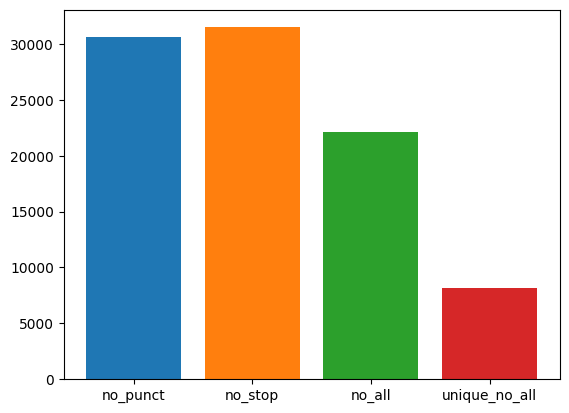

In [20]:
token_data_processing_vis = {
    "no_punct":len(flatten_list(train_collection_no_punct.get_token_list())),
    "no_stop":len(flatten_list(train_collection_no_stopwords.get_token_list())),
    "no_all":len(flatten_list(train_collection_all_removed.get_token_list())),
    "unique_no_all":len(flatten_list(train_collection_unique_no_stop_and_punct.get_token_list()))
}
plt.bar(token_data_processing_vis.keys(), token_data_processing_vis.values(), color=colors)
plt.show() # frequency of classes / labels

Next step is to create 2 more collections for our experiments - stemmed and lemmatization collections. 

Stemming is a text preprocessing technique used to reduce words to their root or base form. The goal of stemming is to simplify and standardize words, which helps improve the performance of text classification. In Lemmatization we also try to reduce a given word to its root word. 

The difference between the two is that in stemming we remove last few characters from a word, often leading to incorrect meanings and spelling. However in lemmatization, we consider the context and convert the word to its meaningful base form, which is called Lemma.

In order to do this, we will import the appropriate NLTK libraries

In [21]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

Then we apply it to the appropriate collections

In [22]:

stemmed_tokens = [[ps.stem(token) for token in token_list]for token_list in train_collection.get_token_list()]
lemmatised_tokens = [[lemmatizer.lemmatize(token) for token in token_list]for token_list in train_collection.get_token_list()]

print("Train original\t\t:", train_collection.get_token_list()[:3])
print("Train stemmed\t\t:", stemmed_tokens[:3])
print("Train lemmatised\t:", lemmatised_tokens[:3])

Train original		: [['for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'persons', 'empowerment', 'scale', '(', 'gypes', ')', 'was', 'developed', '.'], ['the', 'following', 'physiological', 'traits', 'were', 'measured', ':', 'stomatal', 'conductance', '(', 'gs', ',', 'mol', 'h2o', 'm-2', 's-1', ')', ',', 'transpiration', 'rate', '(', 'e', ',', 'mmol', 'h2o', 'm-2', 's-1', ')', ',', 'net', 'photosynthetic', 'rate', '(', 'pn', ',', 'μmol', 'm-2', 's-1', ')', 'and', 'intercellular', 'co2', 'concentration', 'co2', '(', 'ci', ',', 'μmol', 'm-2', 's-1', ')', '.'], ['minor', 'h', 'antigen', 'alloimmune', 'responses', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'leukocyte', 'antigen', '(', 'hla)–matched', 'allogeneic', 'solid', 'organ', 'and', 'stem', 'cell', 'transplantation', '(', 'sct', ')', '[', '3,4', ']', '.']]
Train stemmed		: [['for', 'thi', 'purpos', 'the', 'gothenburg', 'young', 'person', 'empower', 'scale', '(', 'gype', ')', 'wa', 'develop', '.'], ['the', 'follow'

As we can see from above, the stemmer does indeed cut words off to the point where the word itself no longer has meaning. However, on the opposite side, we can see that lemmatising has very little effect on our original tokens. However, the NLTK lemmatiser takes an additional pos tag value: 
    "n" for nouns,
    "v" for verbs, 
    "a" for adjectives, 
    "r" for adverbs and 
    "s" for satellite adjectives.

With this, we can build a slightly more sophisticated lemmatiser and see if it has a more different effect. 

In [23]:
def collection_to_lemma(data_collection:DataCollection) -> DataCollection:
    collection:list[DataRow] = []
    for data_row in data_collection.collection:
        new_row:DataRow = DataRow([], [], [])
        for item_idx, pos in enumerate(data_row.pos):
            token = data_row.tokens[item_idx]
            new_token = ""
            if pos == "NOUN":
                new_token = lemmatizer.lemmatize(token, "n")
            elif pos == "VERB":
                new_token = lemmatizer.lemmatize(token, "v")
            elif pos == "ADJ":
                new_token = lemmatizer.lemmatize(token, "a")
            elif pos == "ADV":
                new_token = lemmatizer.lemmatize(token, "r")
            else:
                new_token = lemmatizer.lemmatize(token)
            new_row.tokens.append(new_token)
            new_row.pos.append(data_row.pos[item_idx])
            new_row.ner.append(data_row.ner[item_idx])
        if len(new_row.tokens) > 0:
            collection.append(new_row)
    new_collection = DataCollection(collection)
    new_collection.set_unique_ner_tags(tag_list)
    return new_collection

lemmatised_collection = collection_to_lemma(train_collection)

print("Train lemmatised\t\t:", lemmatised_tokens[:3])
print("Train lemmatised collection\t:", lemmatised_collection.get_token_list()[:3])

Train lemmatised		: [['for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'person', 'empowerment', 'scale', '(', 'gypes', ')', 'wa', 'developed', '.'], ['the', 'following', 'physiological', 'trait', 'were', 'measured', ':', 'stomatal', 'conductance', '(', 'g', ',', 'mol', 'h2o', 'm-2', 's-1', ')', ',', 'transpiration', 'rate', '(', 'e', ',', 'mmol', 'h2o', 'm-2', 's-1', ')', ',', 'net', 'photosynthetic', 'rate', '(', 'pn', ',', 'μmol', 'm-2', 's-1', ')', 'and', 'intercellular', 'co2', 'concentration', 'co2', '(', 'ci', ',', 'μmol', 'm-2', 's-1', ')', '.'], ['minor', 'h', 'antigen', 'alloimmune', 'response', 'readily', 'occur', 'in', 'the', 'setting', 'of', 'human', 'leukocyte', 'antigen', '(', 'hla)–matched', 'allogeneic', 'solid', 'organ', 'and', 'stem', 'cell', 'transplantation', '(', 'sct', ')', '[', '3,4', ']', '.']]
Train lemmatised collection	: [['for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'person', 'empowerment', 'scale', '(', 'gypes', ')', 'wa', 'develop', '.'],

As we can see, this has still not made much of a difference, but as such, we will test with both of them.

One last thing we can do, is to remove special characters. Sometimes learning these characters can result in the model accuracy dropping and thus we can see if there are any within our dataset and remove them.

In [24]:
def is_special_character(token):
    if len(token) > 1:
        return False
    else:
        return ord(token) < 32 or ord(token) > 127 # true if not special character 


special_chars = []
for token in flatten_list(train_collection.get_token_list()):
    if is_special_character(token):
        special_chars.append(token)
print("Number of Special Characters: ", len(special_chars))
print("Special Characters: ", special_chars)
print("Number of Unique: ", len(list(set(special_chars))))
print("Unique Special: ", list(set(special_chars)))

train_no_special_collection = remove_values(train_collection, list(set(special_chars)))
print("Token count after special removed:", len(flatten_list(train_no_special_collection.get_token_list()))) 

Number of Special Characters:  180
Special Characters:  ['β', 'β', 'λ', 'α', 'α', '±', '•', '–', '—', '–', 'β', '’', '’', '—', '–', 'å', '±', '±', '–', '≤', 'α', '–', '–', '–', '–', '–', '–', '“', '”', 'α', '“', '”', 'β', '–', '–', '°', '–', '“', '”', '–', 'β', '°', '–', '—', '—', '“', '”', '±', '–', '−', 'α', '’', '–', '–', 'α', 'α', '…', '”', '–', '“', '”', '“', '”', 'β', 'β', '‘', '’', '‘', '’', '–', '±', 'β', '–', '‘', '’', '“', '”', '—', '°', '“', '”', '–', '’', '–', '“', '”', '“', '”', 'γ', 'γ', 'γ', 'γ', 'λ', '—', '’', '×', '±', '¯', '±', '—', 'γ', '“', '…', '…', '…', '’', '±', '±', '±', '±', '“', '”', '“', '”', 'β', '“', '”', '®', '®', '®', '®', '®', '®', '®', '♀', '♂', '♀', '♂', '–', '–', '°', 'β', '—', '“', '”', '–', '–', '–', '–', 'α', 'σ', '®', 'β', '–', '§', '“', '”', '“', '”', '“', '”', '“', '”', 'β', '–', '–', '“', '”', '”', '”', '（', '）', '°', '°', '‘', '’', 'γ', '·', '–', 'β', 'β', '–', '±', '±', '±', '±', 'β', '—', '®', 'β']
Number of Unique:  27
Unique Special:  ['σ'

As we can see, we have a total of 180 tokens that are special characters, but only 27 unique special characters. We can also remove those from our train_collection and see if this produces better accuracy.

#### Data Pre-processing - Evaluation

Now that we have set up our data for testing, we require a model to test the accuracy on. As such, we will build the Hugging Face Token Classification model for DistilBERT and test our data on that. Since our data is already in collections, it will be easy to add it as we go.

First thing we have to do is to take our labels and tokenise them. Hugging face offers transformers that help us achieve this by calling the "AutoTokenizer" class. This will return our tokens as a series of input IDs (numbers) and an attention mask (the keys might vary depending on the model, but for DistilBERT, it returns 2 keys). To see this in action, let's look at the the first row of tokens in our train dataset:

In [25]:
from transformers import AutoTokenizer
from transformers import BatchEncoding
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [26]:
tokenized_input:BatchEncoding = tokenizer(train_collection.get_token_list()[0], is_split_into_words=True) # convert tokens to numbers (input_ids) and attention_mask
tokenized_words = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"]) # converts inputs numbers to words again
print("Original Tokens\t:", train_collection.get_token_list()[0])
print("Tokenised Inputs\t:", tokenized_input["input_ids"])
print("Tokenised Inputs to Words\t:", tokenized_words)
print("Original Token Len\t:", len(train_collection.get_token_list()[0]))
print("Tokenised Input Len\t:", len(tokenized_input["input_ids"]))

Original Tokens	: ['for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'persons', 'empowerment', 'scale', '(', 'gypes', ')', 'was', 'developed', '.']
Tokenised Inputs	: [101, 2005, 2023, 3800, 1996, 22836, 2402, 5381, 23011, 4094, 1006, 1043, 18863, 2015, 1007, 2001, 2764, 1012, 102]
Tokenised Inputs to Words	: ['[CLS]', 'for', 'this', 'purpose', 'the', 'gothenburg', 'young', 'persons', 'empowerment', 'scale', '(', 'g', '##ype', '##s', ')', 'was', 'developed', '.', '[SEP]']
Original Token Len	: 15
Tokenised Input Len	: 19


There are two things that we will notice from here. The first is that when tokenisation happens with the autotokeniser, it sometimes decides on its own to split the words even more. For instance, the word "gypes" has been split into "g", "ype" and "s". Secondly, there is a CLS and SEP added to the list of tokens. These two tags mean start and end of tokens (or a sentance) for the model to know.

Because of this, when we print the length of hte original tokens and the new tokenized inputs, we notice that the lengths no longer match up. This will be problem for our labels, as the NER tags are set up to match the length of the tokens. In order to fix this issue, we have to write a function that will "pad" the tokens that have been added with -100.

Helpfully, the tokenizer has a function called "word_ids" that will return the ids of the words sequentially and mark special tokens as "none":

In [27]:
print(tokenized_input.word_ids())

[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 11, 12, 13, 14, None]


As we can see, where the word "gypes" is, it is represented by 3 sequential "10"s that note that the word has been split into three. There is however 1 more issue - DistilBERT supports tokens of only size 512. Because the tokeniser splits our tokens into extra tokens, we need to make sure that we do not let the tokens become longer than 512. However, luckily this has already been handled by the tokenizer function by giving it "max token length". 

With this, we are ready to perform processing our tokens into input ids and padding the ner tags:

In [28]:
def tokenize_and_align_labels(data_collection:DataCollection) -> BatchEncoding:
    tokenized_inputs = tokenizer(data_collection.get_token_list(), truncation=True, is_split_into_words=True, max_length=512) # tokenise inputs

    labels = [] # create empty labels list to later matchs with tokenised inputs

    for i, label in enumerate(data_collection.ner_as_idx): # enumerate ner tags that we have converted to 
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # get word ids
        previous_word_idx = None # previous word index to check if same
        label_ids = [] # create current label ids list
        for word_idx in word_ids:  # for each index
            if word_idx is None:  # if index is none must be special token
                label_ids.append(-100) # append -100
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx]) # if does not equal previous word idx, append the label
            else:
                label_ids.append(-100) # if it does, the word has split so we add -100 again
            previous_word_idx = word_idx # set the current index as previous index for next check
        labels.append(label_ids) # on all processed, add to labels list

    tokenized_inputs["labels"] = labels # add to dictionary, will be input_ids, labels and attention mask
    return tokenized_inputs

Now lets create the tokenisation inputs for all of our experimental collections:

In [29]:
def batch_list(batch:BatchEncoding):
    return [{"input_ids": inputs, "labels": labels} for labels, inputs in zip(batch["labels"], batch["input_ids"])]

train_collection_original = data_to_collection(train_tokens_lower, train_pos_tags, train_ner_tags)
train_collection_stemmed = data_to_collection(stemmed_tokens, train_pos_tags, train_ner_tags)

Now that we have tokenised all of our collections that we will test on, we will be able to generate a metric function to run when we are training our dataset. The metric function is important to progressively test our dataset and see how well it is doing as some models are capable of adjusting rates and values depending on progress.

In [30]:
from datasets import load_metric
import evaluate
seqeval = evaluate.load("seqeval")
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [tag_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [tag_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

# classification_labels:list[str] = train_collection.get_unique_tags(train_collection.get_ner_list()) # this gets all unique classification labels in a list
# embeddings:dict = train_collection.create_item_embeddings(classification_labels)

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\olive\AppData\Local\Temp\ipykernel_54732\3952958676.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\datasets\load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/hug

Finally, let's set up our model to train:

In [31]:
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "distilbert-base-uncased"

# train_model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list), id2label=id2label, label2id=label2id)

In [32]:
def get_training_args(out_dir:str, learning_rate:float=2e-5, batch_size:int=16, epochs:int=2) -> TrainingArguments:
    return TrainingArguments(
        output_dir=out_dir,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs, # number of epochs to train, can be overriden by max steps
        weight_decay=0.01, # The weight decay to apply (if not zero) to all layers except all bias and LayerNorm weights
        evaluation_strategy="epoch", # evaluate at the end of each epoch
        save_strategy="epoch", # can save by epoch, steps or not at all
        save_total_limit=1, # how many checkpoints to keep before overriding (set to 1, so latest checkpoint is only kept)!
        load_best_model_at_end=True,
        report_to=['none'], # REQUIRED because otherwise keeps asking to log into "wandb",
        overwrite_output_dir=True,
    )

# It is important to note that because we are using DistilBERT
# we have access to DistilBERT fast tokeniser. Usually we would have
# to use a data collator to pad the tokens, however when running this,
# we will actually get a warning saying that: 

# "You're using a DistilBertTokenizerFast tokenizer. 
# Please note that with a fast tokenizer, using the `__call__` method is faster than using a 
# method to encode the text followed by a call to the `pad` method to get a padded encoding.

# All this means is that when we do tokenisation, we can already pad our inputs
# by giving the tokeniser the parameter "padding = true". That way
# we can skip the data collator completely as a step
def get_trainer(model, training_args:TrainingArguments, tokenised_train:list[dict], tokenised_eval:list[dict]) -> Trainer:
    return Trainer(
        model=model, # model we use for training
        args=training_args, # model arguments
        train_dataset=tokenised_train, # train dataset tokenised
        eval_dataset=tokenised_eval, # testing dataset tokenised for model training evaluation
        tokenizer=tokenizer, # which tokeniser are we using
        data_collator=data_collator, # data collector pads the tokens along with the labels
        compute_metrics=compute_metrics, # function to compute metrics on how well we are scoring
    )

With the training done, we must do evaluation on the now trained values. To do so, we must predict using our trained model and then getting back a list of predicted labels vs the actual labels. We then parse the predicted labels and actual labels to remove the -100 padding values and add a combination of them to our confusion matrix table. Thus, we will be able to predict the precision, recall and f1 score of our labels / classes.

First let's get the predictions and parse them:

In [33]:
def get_truth_values(given_trainer:Trainer, validation_data_collection:DataCollection, validation_tokenised_list:list[dict], given_label_list):
    # predict function returns the following:
    # Returns: *NamedTuple* A namedtuple with the following keys:
    # predictions (np.ndarray): The predictions on test_dataset.
    # label_ids (np.ndarray, *optional*): The labels (if the dataset contained some).
    # metrics (Dict[str, float], *optional*): The potential dictionary of metrics (if the dataset contained labels).
    given_predictions, given_labels, _ = given_trainer.predict(validation_tokenised_list)
    true_predictions = []
    true_labels = []

    given_predictions = np.argmax(given_predictions, axis=2)
    for prediction, label in zip(given_predictions, given_labels):
        for (pred_val, label_val) in zip(prediction, label):
            if label_val != -100: # label that is not supposed to be looked at!
                true_predictions.append(given_label_list[pred_val])
                true_labels.append(given_label_list[label_val])
                
    return true_predictions, true_labels

In [34]:
import pandas as pd

def trained_model_to_dataframe(trained_model:Trainer, validation_data_collection:DataCollection, validation_tokenised_in:list[dict], label_list_in:dict) -> pd.DataFrame:
    truth_predicitons, truth_labels = get_truth_values(trained_model, validation_data_collection, validation_tokenised_in, label_list_in)

    df = pd.DataFrame(0, columns=label_list_in, index=label_list_in) # create dataframe with only zeroes but all labels!

    for true_label, predict_label in zip(truth_labels, truth_predicitons):
        df.at[true_label, predict_label] += 1 # count amount of labels
    return df


With all of our predictions in a dataframe, all that is left is to plot confusion matrcies and calculate scores. In order to calculate the scores, we can find a handy guide to formulas here: https://www.w3schools.com/python/python_ml_confusion_matrix.asp

We could call trainer.evaluate() to get our model scores, but we will evaluate ourselves to get an accurate scoring. Since F1 will be our main metric here, we need to calculate recall and precision first. The formulas would be:

- Precision = True Positive / (True Positive + False Positive)
- Recall = True Positive / (True Positive + False Negative)
- F1 = 2 * ((Precision * Recall) / (Precision + Recall))

In our case, because we want to predict long froms and abbreviations, B-LF, I-LF and B-AC are true positives and since everything else is B-O, that is our true negative. If we predict B-LF, I-LF or B-AC incorrectly, that is a false positive and predicting B-O incorrectly is false negative.

We will also want to normalise our dataframes so we can see precentage wise how many values we got correct when we visualise. To do so, we sum each row and then divide every column values in that row by the sum.

In [35]:
def calc_precision(TP, FP) -> float:
    return TP / (TP + FP)

def calc_recall(TP, FN) -> float:
    return TP / (TP + FN)

def calc_f1_score(precision, recall) -> float:
    return 2 * ((precision * recall) / (precision + recall))

def calculate_metrics(data_frame:pd.DataFrame) -> dict:
    tn_labels = ["B-O"]
    tp_labels = ["B-AC", "B-LF", "I-LF"]
    
    TN = 0
    TP = 0
    FP = 0
    FN = 0

    for tn_label in tn_labels:
        TN += data_frame.at[tn_label, tn_label]
    for tp_label in tp_labels:
        TP += data_frame.at[tp_label, tp_label]
    for tp_label in tp_labels:
        FN += data_frame.at["B-O", tp_label]
    for tp_label in tp_labels:
        fp_list = tn_labels + tp_labels
        fp_list.remove(tp_label)
        for fp_label in fp_list:
            FP += data_frame.at[tp_label, fp_label]

    prec = calc_precision(TP, FP)
    rec = calc_recall(TP, FN)
    f1 = calc_f1_score(prec, rec)
    return {
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt

def plot_dataframe(dataframe:pd.DataFrame, normalised:bool=True) -> ConfusionMatrixDisplay:
    if normalised:
        result_df = dataframe.div(dataframe.sum(axis=1), axis=0)
    else:
        result_df = dataframe

    disp = ConfusionMatrixDisplay(confusion_matrix=result_df.to_numpy(), display_labels=list(result_df.index)) 
    return disp
    # disp.plot() 
    # plt.show()

def plot_and_metric(plot_df, normalise=True, name="") -> tuple[ConfusionMatrixDisplay, dict]:
    # print("\n\n\n##############\nPlot Name: ", name)
    disp = plot_dataframe(plot_df, normalise)
    metrics = calculate_metrics(plot_df)
    return disp, metrics

In [60]:
import os
import shutil
import time

working_dir = os.getcwd()
def get_exp_checkpoint(exp_path:str):
    exp_dir:str = os.path.join(working_dir, exp_path)
    checkpoint_name:str = os.listdir(exp_dir)[0] # selects first checkpoint name found
    return os.path.join(exp_dir, checkpoint_name)

def delete_previous_checkpoints(exp_name:str) -> None:
    # delete all previous checkpoint to make sure we are not keeping anything if retraining
    exp_dir:str = os.path.join(working_dir, "exp_1", exp_name)
    if os.path.exists(exp_dir):
        checkpoint_name:str = os.listdir(exp_dir)[0]
        checkpoint_path:str = os.path.join(exp_dir, checkpoint_name)
        if os.path.exists(checkpoint_path):
            shutil.rmtree(checkpoint_path)

def run_train_and_plot_pipeline(
    train_data_collection:DataCollection,
    test_data_collection:DataCollection=test_collection,
    validation_data_collection:DataCollection=validation_collection,
    retrain_model:bool=True,
    train_model_checkpoint_name:str="distilbert-base-uncased", # if we re-train use this 
    exp_path:str="exp_test", # otherwise to load data, will use this
    epochs:int=2,
) -> tuple[ConfusionMatrixDisplay, dict, str, dict]: 
    label_list:list[str] = train_data_collection.unique_ner_tags
    id2label:dict = train_data_collection.ner_idx2label
    label2id:dict = train_data_collection.ner_label2idx
    if retrain_model:
        delete_previous_checkpoints(exp_path)
        model = AutoModelForTokenClassification.from_pretrained(
            train_model_checkpoint_name, 
            num_labels=len(label_list), 
            id2label=id2label, 
            label2id=label2id)
    else:
        model =  AutoModelForTokenClassification.from_pretrained(
            get_exp_checkpoint(exp_path), 
            num_labels=len(label_list), 
            id2label=id2label, 
            label2id=label2id)
        
    train_tokenised = batch_list(tokenize_and_align_labels(train_data_collection))
    test_tokenised = batch_list(tokenize_and_align_labels(test_data_collection))
    validation_tokenised = batch_list(tokenize_and_align_labels(validation_data_collection))

    trainer:Trainer = get_trainer(
        model,
        get_training_args(out_dir=exp_path, epochs=epochs), 
        train_tokenised, 
        test_tokenised)
    
    train_metric = {
        "retrained":retrain_model,
        "train_time":"",
        "epochs":epochs
    }
    if retrain_model:
        training_start_time = time.time()
        trainer.train()
        train_metric["train_time"] = '{:.2f}s'.format(time.time() - training_start_time)
        
    pipeline_df:pd.DataFrame = trained_model_to_dataframe(trainer, validation_data_collection, validation_tokenised, train_data_collection.unique_ner_tags)
    disp, metric_dict = plot_and_metric(pipeline_df, name=exp_path)
    return disp, metric_dict, exp_path, train_metric
    



In [61]:
retrain_exp_1:bool = True 
epoch_to_train:int = 50
plots:list[tuple[ConfusionMatrixDisplay, dict, str, dict]] = []

In [62]:
plots.append(run_train_and_plot_pipeline(train_collection_original, retrain_model=retrain_exp_1, exp_path="exp_1/orig", epochs=epoch_to_train))

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/3350 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
plots.append(run_train_and_plot_pipeline(train_collection, retrain_model=retrain_exp_1, exp_path="exp_1/lower", epochs=epoch_to_train))


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.22932010889053345, 'eval_precision': 0.9175471307230164, 'eval_recall': 0.9395417904115401, 'eval_f1': 0.9284142123467143, 'eval_accuracy': 0.915, 'eval_runtime': 0.1753, 'eval_samples_per_second': 872.706, 'eval_steps_per_second': 57.04, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checkpoint destination directory exp_1/lower\checkpoint-134 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.1949075609445572, 'eval_precision': 0.9340058848255569, 'eval_recall': 0.9427238014425117, 'eval_f1': 0.9383445945945945, 'eval_accuracy': 0.93, 'eval_runtime': 0.1803, 'eval_samples_per_second': 848.785, 'eval_steps_per_second': 55.476, 'epoch': 2.0}
{'train_runtime': 8.1204, 'train_samples_per_second': 264.025, 'train_steps_per_second': 16.502, 'train_loss': 0.39013247703438375, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
plots.append(run_train_and_plot_pipeline(train_collection_no_punct, retrain_model=retrain_exp_1, exp_path="exp_1/punct", epochs=epoch_to_train))


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.35104531049728394, 'eval_precision': 0.8784, 'eval_recall': 0.9316928298684769, 'eval_f1': 0.9042618900555899, 'eval_accuracy': 0.8822, 'eval_runtime': 0.1722, 'eval_samples_per_second': 888.246, 'eval_steps_per_second': 58.055, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checkpoint destination directory exp_1/punct\checkpoint-134 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.29147711396217346, 'eval_precision': 0.8894259818731118, 'eval_recall': 0.9367840475180313, 'eval_f1': 0.9124909598098977, 'eval_accuracy': 0.9008, 'eval_runtime': 0.1816, 'eval_samples_per_second': 842.643, 'eval_steps_per_second': 55.075, 'epoch': 2.0}
{'train_runtime': 7.3452, 'train_samples_per_second': 291.347, 'train_steps_per_second': 18.243, 'train_loss': 0.5335425761208605, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
plots.append(run_train_and_plot_pipeline(train_collection_no_stopwords, retrain_model=retrain_exp_1, exp_path="exp_1/stop", epochs=epoch_to_train))


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.24580273032188416, 'eval_precision': 0.9101931771475544, 'eval_recall': 0.9395417904115401, 'eval_f1': 0.924634655532359, 'eval_accuracy': 0.9138, 'eval_runtime': 0.1768, 'eval_samples_per_second': 865.255, 'eval_steps_per_second': 56.553, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checkpoint destination directory exp_1/stop\checkpoint-134 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.20839430391788483, 'eval_precision': 0.931077694235589, 'eval_recall': 0.9456936784047518, 'eval_f1': 0.938328772889918, 'eval_accuracy': 0.9316, 'eval_runtime': 0.1776, 'eval_samples_per_second': 861.657, 'eval_steps_per_second': 56.317, 'epoch': 2.0}
{'train_runtime': 7.7002, 'train_samples_per_second': 278.434, 'train_steps_per_second': 17.402, 'train_loss': 0.4442161730865934, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
plots.append(run_train_and_plot_pipeline(train_collection_all_removed, retrain_model=retrain_exp_1, exp_path="exp_1/stop_punct", epochs=epoch_to_train))


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.48051562905311584, 'eval_precision': 0.8765753150630126, 'eval_recall': 0.9295714891811625, 'eval_f1': 0.9022958921033667, 'eval_accuracy': 0.8808, 'eval_runtime': 0.1861, 'eval_samples_per_second': 822.27, 'eval_steps_per_second': 53.743, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checkpoint destination directory exp_1/stop_punct\checkpoint-134 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.408941388130188, 'eval_precision': 0.8865191146881287, 'eval_recall': 0.9346627068307171, 'eval_f1': 0.9099545642296571, 'eval_accuracy': 0.8976, 'eval_runtime': 0.1848, 'eval_samples_per_second': 827.755, 'eval_steps_per_second': 54.102, 'epoch': 2.0}
{'train_runtime': 6.9601, 'train_samples_per_second': 307.467, 'train_steps_per_second': 19.253, 'train_loss': 0.6691362181706215, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
plots.append(run_train_and_plot_pipeline(train_collection_unique_no_stop_and_punct, retrain_model=retrain_exp_1, exp_path="exp_1/unique_punct_stop", epochs=epoch_to_train))


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.6091961860656738, 'eval_precision': 0.8646, 'eval_recall': 0.9170555791260077, 'eval_f1': 0.8900555898702902, 'eval_accuracy': 0.8646, 'eval_runtime': 0.1878, 'eval_samples_per_second': 814.698, 'eval_steps_per_second': 53.248, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Checkpoint destination directory exp_1/unique_punct_stop\checkpoint-130 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.5067582726478577, 'eval_precision': 0.8842, 'eval_recall': 0.9378447178616885, 'eval_f1': 0.9102326539015853, 'eval_accuracy': 0.8842, 'eval_runtime': 0.1801, 'eval_samples_per_second': 849.611, 'eval_steps_per_second': 55.53, 'epoch': 2.0}
{'train_runtime': 5.5577, 'train_samples_per_second': 373.534, 'train_steps_per_second': 23.391, 'train_loss': 0.7701832697941706, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plots.append(run_train_and_plot_pipeline(train_collection_stemmed, retrain_model=retrain_exp_1, exp_path="exp_1/stemmed", epochs=epoch_to_train))


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.2690446674823761, 'eval_precision': 0.9130704109023333, 'eval_recall': 0.93805685193042, 'eval_f1': 0.9253949984304699, 'eval_accuracy': 0.9078, 'eval_runtime': 0.1837, 'eval_samples_per_second': 833.053, 'eval_steps_per_second': 54.448, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checkpoint destination directory exp_1/stemmed\checkpoint-134 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.2188536673784256, 'eval_precision': 0.9295302013422819, 'eval_recall': 0.9401781926177344, 'eval_f1': 0.9348238768192365, 'eval_accuracy': 0.921, 'eval_runtime': 0.1831, 'eval_samples_per_second': 835.71, 'eval_steps_per_second': 54.622, 'epoch': 2.0}
{'train_runtime': 8.7725, 'train_samples_per_second': 244.4, 'train_steps_per_second': 15.275, 'train_loss': 0.4205961654435343, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
plots.append(run_train_and_plot_pipeline(lemmatised_collection, retrain_model=retrain_exp_1, exp_path="exp_1/lemma", epochs=epoch_to_train))


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.23843753337860107, 'eval_precision': 0.9192443429520448, 'eval_recall': 0.9393296563428086, 'eval_f1': 0.9291784702549575, 'eval_accuracy': 0.9148, 'eval_runtime': 0.1942, 'eval_samples_per_second': 787.682, 'eval_steps_per_second': 51.482, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checkpoint destination directory exp_1/lemma\checkpoint-134 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.20004191994667053, 'eval_precision': 0.9337260677466863, 'eval_recall': 0.941450997030123, 'eval_f1': 0.9375726206823704, 'eval_accuracy': 0.928, 'eval_runtime': 0.192, 'eval_samples_per_second': 796.818, 'eval_steps_per_second': 52.08, 'epoch': 2.0}
{'train_runtime': 8.327, 'train_samples_per_second': 257.475, 'train_steps_per_second': 16.092, 'train_loss': 0.39720116800336697, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
plots.append(run_train_and_plot_pipeline(train_no_special_collection, retrain_model=retrain_exp_1, exp_path="exp_1/special", epochs=epoch_to_train))

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\olive\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

{'eval_loss': 0.22739125788211823, 'eval_precision': 0.9181686347627926, 'eval_recall': 0.9401781926177344, 'eval_f1': 0.9290430772455718, 'eval_accuracy': 0.9158, 'eval_runtime': 0.1807, 'eval_samples_per_second': 846.528, 'eval_steps_per_second': 55.329, 'epoch': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Checkpoint destination directory exp_1/special\checkpoint-134 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 0.19456930458545685, 'eval_precision': 0.9331511456800504, 'eval_recall': 0.9416631310988545, 'eval_f1': 0.9373878154365959, 'eval_accuracy': 0.9298, 'eval_runtime': 0.1937, 'eval_samples_per_second': 790.078, 'eval_steps_per_second': 51.639, 'epoch': 2.0}
{'train_runtime': 8.2621, 'train_samples_per_second': 259.499, 'train_steps_per_second': 16.219, 'train_loss': 0.38997786792356576, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

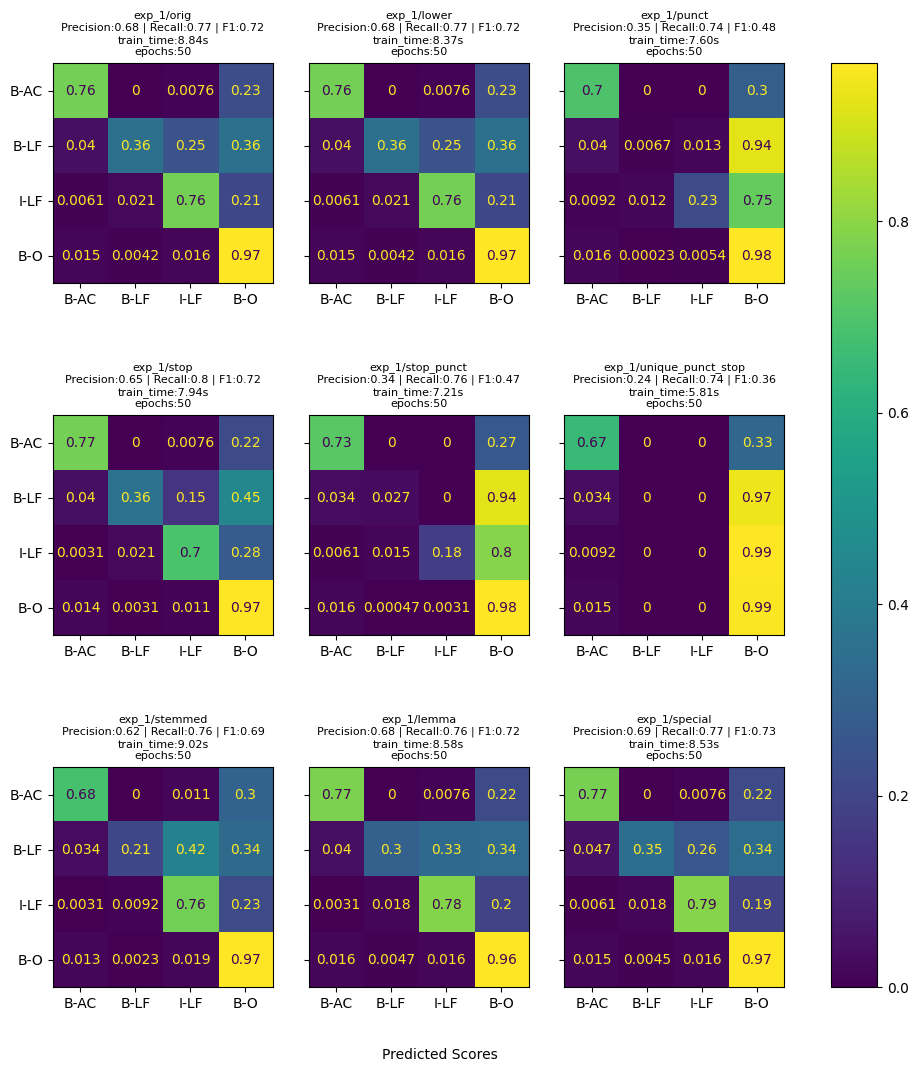

In [ ]:
import math
plot_column_num:int = 3
number_of_plots:int = len(plots)
plot_row_num:int = math.ceil(number_of_plots/plot_column_num)

fix_size = 12

f, axes = plt.subplots(plot_row_num, plot_column_num, figsize=(fix_size, fix_size), sharey='row')
idx_row = 0
for idx, (disp, metric_dict, name, train_dict) in enumerate(plots):
    idx_col = idx % plot_column_num
    if idx != 0 and idx_col == 0:
        idx_row += 1

    title = str(name)+"\n"
    for idx, (k,v) in enumerate(metric_dict.items()):
        if idx < len(metric_dict.items())-1:
            title += str(k)+":"+str(float("{:.2f}".format(v)))+" | "
        else:
            title += str(k)+":"+str(float("{:.2f}".format(v)))

    if train_dict["retrained"]:
        for idx, (k,v) in enumerate(train_dict.items()):
            if idx != 0:
                title += "\n"+str(k)+":"+str(v)

    disp.plot(ax=axes[idx_row,idx_col])
    disp.ax_.set_title(title).set_fontsize(8)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if idx!=0:
        disp.ax_.set_ylabel('')


f.text(0.41, 0.05, 'Predicted Scores', ha='left')
# plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.subplots_adjust(wspace=0.1, hspace=0.6)
f.colorbar(disp.im_, ax=axes)
plt.show()

Talk about accuracy, speed and draw confusion matrix